# Adjusting Intralaminar Connectivity

In this notebook we use the [Allen Institute synaptic physiology dataset](https://portal.brain-map.org/explore/connectivity/synaptic-physiology) to outline our procedure for making connectivity adjustments imposed by the experimental constraints of slice physiology.

For an introduction to the Jupyter Notebook interface, try [Codeacademy: How To Use Jupyter Notebooks]( https://www.codecademy.com/articles/how-to-use-jupyter-notebooks) or [Jupyter Notebook Quick Start Guide](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html).


Multipatch slice electrophysiology is one of the best methods for indepth characterization of synaptic connections. However, a consistent criticism of slice physgiology is that measured connection probability (Cp) is a lower bounds of the true Cp due to severing of processes during slicing. It is also the case that electrophysiological recordings contain some amount of baseline noise. The level of this can be cell type dependent and may obscure very small responses unless we can average many many responses together, which is ultimately related to how long we record from the cells. It is also known from prior slice physiology studies that the rate of connectivity declines as cells get further from each other.

This notebook will explore the magnitude of these parameters on accurately measruing Cp, the approach we take to adjust our connectivity measurement, and how you could apply this adjustment to your own data.

In [1]:
from aisynphys.database import SynphysDatabase
from aisynphys.cell_class import CellClass, classify_cells, classify_pairs
import numpy as np

In [ ]:
# Download and cache the sqlite file for the requested database
#   (for available versions, see SynphysDatabase.list_versions)
db = SynphysDatabase.load_current('small')

Let's first get all of the mouse pairs that were probed for connectivity

In [38]:
mouse_pairs = db.pair_query(
    experiment_type='standard multipatch',
    species='mouse',
    synapse_probed=True).all()
print("loaded %d cell pairs" % len(mouse_pairs))

loaded 23311 cell pairs


We explored 4 parameters and their relationship to connection probability:
1. Lateral inter-somatic distance
2. Presynaptic cell axon length
3. Depth of the pair from the slice surface
4. Signal-to-noise of the postsynaptic recording which we define as "detection power"

These data are available in the SynPhys Database but, with the exception of lateral distance, are not direct attributes of the Pair class. Our first step is to add these parameters.

In [16]:
from aisynphys.connectivity import CorrectionMetricFunctions

# we are going to create some empty dictionaries for each parameter that we will fill in later with some helpful utilities.
adjustment_params = {
    'lateral_distance': {},
    'pre_axon_length': {},
    'avg_pair_depth': {},
    'detection_power': {}, # detection power is a combination of the number of presynaptic test spikes (n_test_spikes) and the
                           # baseline noise level of the postsynaptic cell (baseline_sd_noise). Both of these are also available
                           # in the CorrectionMetricFunctions
}

In [39]:
# We'll now make a new list of pairs with these attributes attached, this can take a couple of minutes
attributes = list(adjustment_params.keys())
extended_pairs = []
for pair in mouse_pairs:
    # Do a couple of checks on the data first:
    if  (# must have a true/false connection call
        pair.has_synapse is not None and
        # intersomatic distance < 500 µm (removes some bad data with very large distances)
        pair.lateral_distance is not None and
        pair.lateral_distance < 500e-6) is False:
        continue
    for attr in attributes:
        if hasattr(pair, attr):
            continue
        attr_func = getattr(CorrectionMetricFunctions, attr)
        val = attr_func(pair)
        setattr(pair, attr, val)
    
    extended_pairs.append(pair)

Now we can see what the relationship is between these parameters and our estimate of connection probability. To do that we will bin each parameter and ask what the rate of connectivity (number of connections found / number connections probed) for that bin as well as the 95% confidence interval using `connectivity_profile`. Here's where we will start to fill in our parameter dictionaries with our bin width as well as some other convenient attributes for plotting.

In [28]:
# Make a convenience function for plot formatting

def format_plot(conn, probed, ax, metric_opts):
    alpha = metric_opts['alpha']
    ymax = metric_opts['ymax']
    tickheight = ymax / 10
    offset = 2
    ax.eventplot(probed.copy(), lineoffsets=-tickheight*offset, linelengths=tickheight, color=((0, 0, 0) + (alpha[0],)))
    ax.eventplot(probed[conn], lineoffsets=-tickheight*(offset-1), linelengths=tickheight, color=((0, 0, 0) + (alpha[1],)))
    ax.axhline(0, color=(0, 0, 0))
    
    x_bins = metric_opts['xbins']
    interval = x_bins[1] - x_bins[0]
    x_vals = np.linspace(x_bins[0], x_bins[-1], 200)
    xticks = np.arange(0, x_vals.max(), interval)
    ax.set_xticks(xticks)
    tick_labels = ['%0.1f'%(x*metric_opts['scale']) for x in xticks]
    trailing_zero = [label.strip('.')[-1] == '0' for label in tick_labels]
    if all(trailing_zero):
        tick_labels = ['%0.0f'%(x*metric_opts['scale']) for x in xticks] 
    ax.set_xticklabels(tick_labels, fontsize=8)
    ax.set_xlim(x_bins[0], x_bins[-1])
    
    y_vals = np.arange(0, ymax + 0.1, 0.1)
    ax.set_yticks([-tickheight*2, -tickheight] + list(y_vals))
    ax.set_yticklabels(['probed', 'connected'] + ['%0.1f'%x for x in y_vals], fontsize=8)
    ax.set_ylim(-tickheight*2.6, ymax)
    x_label = "%s (%s)" % (metric_opts['label'], metric_opts['units'])
    ax.set_xlabel(x_label, fontsize=8)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

In [30]:
# Now we can fill in our attribute dictionaries
adjustment_params.update({
    'lateral_distance': 
    {
        'ymax': 0.25,
        'xbins': np.arange(0, 400e-6, 60e-6),
        'alpha':[0.01, 0.1], # this just sets the shading of the raster tick marks
        'units': 'µm', 
        'scale': 1e6,
        'label': 'Lateral Distance',
    },
    
    'pre_axon_length':
    {
         'ymax': 0.2, 
         'xbins': np.arange(0, 280e-6, 40e-6), 
         'alpha':[0.03, 0.3],
         'label': 'Pre-syn axon length', 
         'units': 'µm', 
         'scale': 1e6,
    },
    
    'avg_pair_depth':
    {
         'ymax': 0.2, 
         'xbins': np.arange(0, 200e-6, 30e-6), 
         'alpha': [0.01, 0.1], 
         'label': 'Avg pair depth', 
         'units': 'µm', 
         'scale': 1e6, 
    },
    
    'detection_power':
    {
         'ymax': 0.3, 
         'xbins': np.arange(3.4, 5.21, 0.2), 
         'alpha': [0.01, 0.1], 
         'units': 'a.u.', 
         'scale': 1, 
         'label': 'Log10 detection power',
    },
 }
)


`connectivity_profile()` takes 2 arrays of connectivity data as well as an array defining the bin edges. The `probed` array is an array of the parameter of interest such as intersomatic distance, presynaptic axon length, etc. The `connected` array should be a boolean denoting whether a connection was present or not at the matching index of `probed`. This will return the connection probability along with lower and upper CIs.

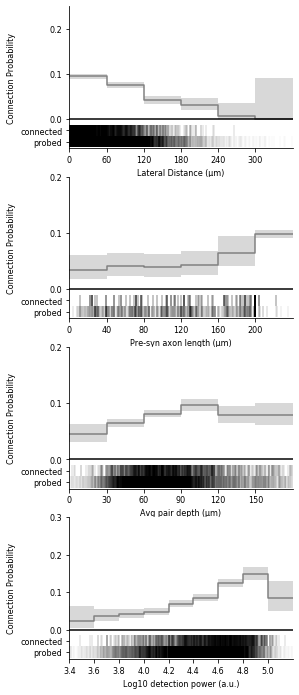

In [40]:
from aisynphys.connectivity import connectivity_profile
from aisynphys.ui.notebook import show_distance_binned_cp
import matplotlib.pyplot as plt

# set up a subplots
fig, ax = plt.subplots(len(adjustment_params), 1, figsize=(4, 12)) 

for i, (param, opts) in enumerate(adjustment_params.items()):
    # get the probed parameter and connected boolean, mask for where both of these arrays are finite
    probed = np.array([getattr(pair,param) for pair in extended_pairs], dtype=float)
    connected = np.array([pair.has_synapse for pair in extended_pairs], dtype=bool)
    mask = np.isfinite(probed) & np.isfinite(connected)
    
    x_bins = opts['xbins']  
    _, cprop, lower, upper = connectivity_profile(connected[mask], probed[mask], x_bins)
    show_distance_binned_cp(x_bins, cprop, ax[i], ci_lower=lower, ci_upper=upper)
    format_plot(connected, probed, ax[i], opts)
    ax[i].set_ylabel('Connection Probability', fontsize=8)

These plots display the data in multiple ways. The raster plots on the bottom show ticks for each connection probed on the bottom and another tick above if a connection was present. These data are binned in the step plots where the thicker grey line shows the connection probability in that bin and the grey shaded area the 95% CI. From these plots we can say that connection probability decreases with increasing lateral distance while connection probability increases with more intact presynaptic axons, deeper recording depths, and higher detection power (or signal-to-noise).

Instead of binning the data we can model the relationship as a continuous function. After much trial and error we determined that the following models worked well for each of these parameters. 
1. Lateral distance - Gaussian model
2. Presynaptic axon length - Binary model. This is mostly borne out of our analysis of axon length which maxed out at 200µm. If your data has a more continuous distribution of axon lengths this model may be different.
3. Pair depth - Error function
4. Detection power - Error function

In [33]:
from aisynphys.connectivity import GaussianModel, BinaryModel, ErfModel

adjustment_params['lateral_distance'].update(
        {
        'model': GaussianModel,
        'model_opts':{
            'method':'L-BFGS-B', 
            'init': (0.1, 100e-6), 
            'bounds': ((0.001, 1), (100e-6, 100e-6))
        }
        }
)
adjustment_params['pre_axon_length'].update(
        {
        'model': BinaryModel, 
        'model_opts': {
             'init': (0.1, 200e-6, 0.5), 
             'bounds': ((0.001, 1), (200e-6, 200e-6), (0.1, 0.9)), 
        }
        }
)
adjustment_params['avg_pair_depth'].update(
        {
        'model': ErfModel, 
        'model_opts':{
         'init': (0.1, 30e-6, 30e-6), 
         'bounds': ((0.01, 1), (10e-6, 200e-6), (-100e-6, 100e-6)),
        }
        }
)
adjustment_params['detection_power'].update(
        {
        'model': ErfModel,
        'model_opts':{
         'init': (0.1, 1.0, 3.0), 
         'bounds': ((0.001, 1), (0.1, 5), (2, 5)), 
         'constraint': (0.6745, np.nanquantile(np.array([getattr(p, 'detection_power') for p in extended_pairs], dtype=float), 0.75))
        }
        }
)


Let's see how these models fit the data

c:\users\stephanies\aisynphys\aisynphys\connectivity.py:357: RuntimeWarning: divide by zero encountered in log
  return np.log(p[conn]).sum() + np.log((1-p)[~conn]).sum()


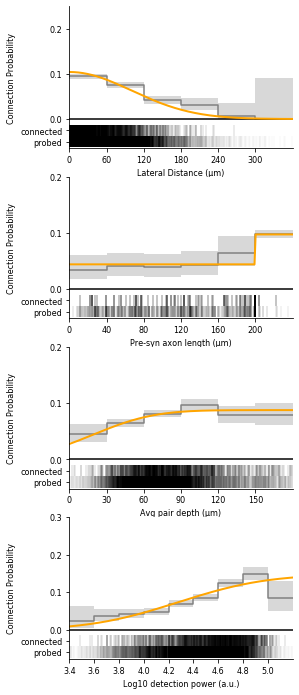

In [47]:
# We'll start by replotting what we have above and then add the model fits to it
fig, ax = plt.subplots(len(adjustment_params), 1, figsize=(4, 12)) 

for i, (param, opts) in enumerate(adjustment_params.items()):
    # get the probed parameter and connected boolean, mask for where both of these arrays are finite
    probed = np.array([getattr(pair,param) for pair in extended_pairs], dtype=float)
    connected = np.array([pair.has_synapse for pair in extended_pairs], dtype=bool)
    mask = np.isfinite(probed) & np.isfinite(connected)
    
    x_bins = opts['xbins']  
    x_vals = np.linspace(x_bins[0], x_bins[-1], 200)
    _, cprop, lower, upper = connectivity_profile(connected[mask], probed[mask], x_bins)
    show_distance_binned_cp(x_bins, cprop, ax[i], ci_lower=lower, ci_upper=upper)
    format_plot(connected, probed, ax[i], opts)
    ax[i].set_ylabel('Connection Probability', fontsize=8)
    
    # fit the model
    model = opts['model']
    model_opts = opts['model_opts']
    fit = model.fit(probed[mask], connected[mask], **model_opts)
    ax[i].plot(x_vals, fit.connection_probability(x_vals), color='orange', lw=2)

These fits look pretty good. Here we've pooled all cell and connection types together, though we might imagine that some of these parameters have cell-type dependencies based on morphology or intrinsic electrophysiological properties. However, these models work best at estimating the relationship when there is a lot of data. As a compromise we can at least split our cells and pairs into their excitatory and inhibitory class.

In [42]:
ei_classes = {
    'ex': CellClass(cell_class_nonsynaptic='ex', name='ex'), 
    'in': CellClass(cell_class_nonsynaptic='in', name='in'),
}
ei_cell_groups = classify_cells(ei_classes.values(), pairs=extended_pairs)
ei_pair_groups = classify_pairs(extended_pairs, ei_cell_groups)

c:\users\stephanies\aisynphys\aisynphys\connectivity.py:357: RuntimeWarning: divide by zero encountered in log
  return np.log(p[conn]).sum() + np.log((1-p)[~conn]).sum()
c:\users\stephanies\aisynphys\aisynphys\connectivity.py:357: RuntimeWarning: divide by zero encountered in log
  return np.log(p[conn]).sum() + np.log((1-p)[~conn]).sum()
c:\users\stephanies\aisynphys\aisynphys\connectivity.py:357: RuntimeWarning: divide by zero encountered in log
  return np.log(p[conn]).sum() + np.log((1-p)[~conn]).sum()
c:\users\stephanies\aisynphys\aisynphys\connectivity.py:357: RuntimeWarning: divide by zero encountered in log
  return np.log(p[conn]).sum() + np.log((1-p)[~conn]).sum()


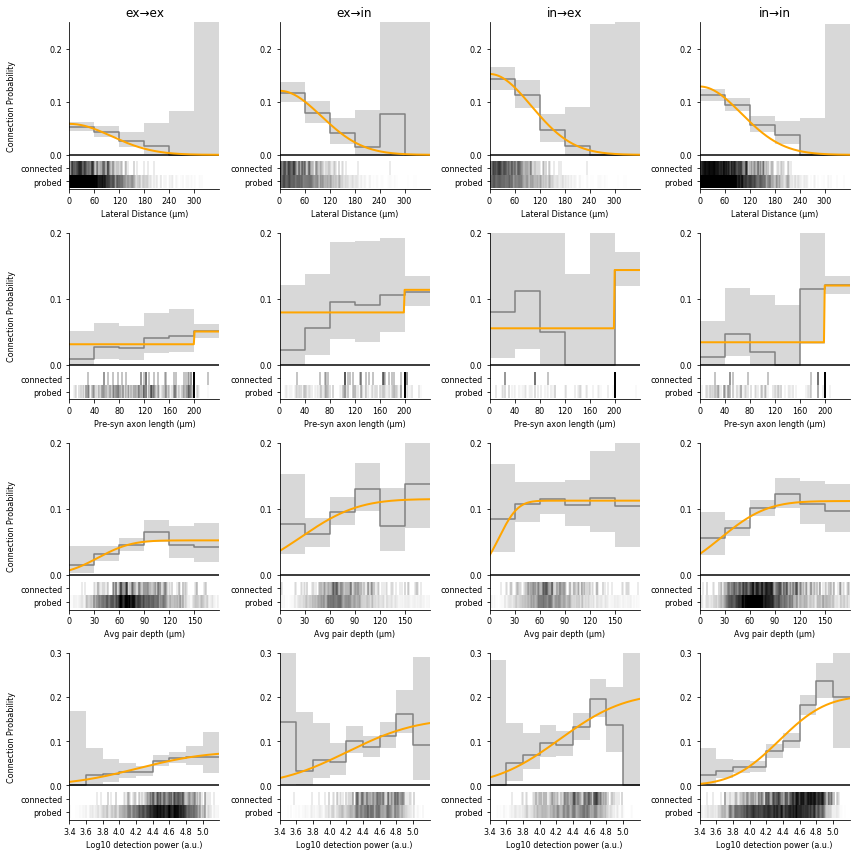

In [52]:
fig, ax = plt.subplots(len(adjustment_params), len(ei_pair_groups), figsize=(12, 12))

for j, (pair_group, pairs) in enumerate(ei_pair_groups.items()):
    for i, (param, opts) in enumerate(adjustment_params.items()):
        
        probed = np.array([getattr(pair,param) for pair in pairs], dtype=float)
        connected = np.array([pair.has_synapse for pair in pairs], dtype=bool)
        mask = np.isfinite(probed) & np.isfinite(connected)

        x_bins = opts['xbins']  
        x_vals = np.linspace(x_bins[0], x_bins[-1], 200)
        _, cprop, lower, upper = connectivity_profile(connected[mask], probed[mask], x_bins)
        show_distance_binned_cp(x_bins, cprop, ax[i,j], ci_lower=lower, ci_upper=upper)
        format_plot(connected, probed, ax[i,j], opts)

        # fit the model
        model = opts['model']
        model_opts = opts['model_opts']
        fit = model.fit(probed[mask], connected[mask], **model_opts)
        ax[i, j].plot(x_vals, fit.connection_probability(x_vals), color='orange', lw=2)
        ax[i, 0].set_ylabel('Connection Probability', fontsize=8)
        
    ax[0, j].set_title("%s→%s" % (pair_group[0], pair_group[1]), fontsize=12)
plt.tight_layout()

These plots show that the effect of these parameters on our estimate of connectivity varies by cell class. For example the lateral distance and detection power have greater effect on connetions involving inhibitory cells than it does on recurrent excitatory connections. With these models in hand, we can apply them to our measured rate of connectivity to get a more accurate estimate of connectivity without these biases.